In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from us import states

from COS513 import load_all_years_of_noaa_storm_data
from COS513 import load_census_data
from COS513 import load_county_zone_mapping
from COS513 import decode_damage_property

# Data

    - NOAA Damage Data
    - Census Data

In [2]:
noaa_data = load_all_years_of_noaa_storm_data()
census_data = load_census_data()
county_zone_mapping = load_county_zone_mapping()

Loading NOAA storm data:   0%|          | 0/75 [00:00<?, ?it/s]

In [3]:
# only keep CONUS
idx = noaa_data['STATE_FIPS'] <= 56.5
noaa_data = noaa_data[idx].reset_index(drop=True)
noaa_data = noaa_data[noaa_data['CZ_TYPE'] != 'M'].reset_index(drop=True) # Marine regions

# format FIPS codes
noaa_data['STATE_FIPS'] = noaa_data['STATE_FIPS'].astype(int).astype(str).str.zfill(2)
noaa_data['CZ_FIPS'] = noaa_data['CZ_FIPS'].astype(int).astype(str).str.zfill(3)
fips_to_abbreviation_map = {s.fips: s.abbr for s in states.STATES}
noaa_data['STATE_ABBREVIATION'] = noaa_data['STATE_FIPS'].map(fips_to_abbreviation_map)
noaa_data['STATE_ZONE'] = noaa_data['STATE_ABBREVIATION'] + noaa_data['CZ_FIPS']


county_zone_mapping_trimmed = county_zone_mapping[['STATE_ZONE', 'FIPS', 'LAT', 'LON']].copy()
noaa_data = noaa_data.merge(
    county_zone_mapping_trimmed,
    on='STATE_ZONE',
    how='left'
)

# Now format the COUNTY_FIPS column
noaa_data['COUNTY_FIPS'] = np.nan
noaa_data['COUNTY_FIPS'] = noaa_data['COUNTY_FIPS'].astype(str)
noaa_data.loc[noaa_data['CZ_TYPE'] == 'C', 'COUNTY_FIPS'] = noaa_data.loc[noaa_data['CZ_TYPE'] == 'C', 'CZ_FIPS']
noaa_data.loc[noaa_data['CZ_TYPE'] == 'Z', 'COUNTY_FIPS'] = noaa_data.loc[noaa_data['CZ_TYPE'] == 'Z', 'FIPS'].str[2:]
noaa_data['STATE_COUNTY_FIPS'] = noaa_data['STATE_FIPS'] + noaa_data['COUNTY_FIPS']

# Format Damage Columns
noaa_data['DAMAGE_PROPERTY'] = noaa_data['DAMAGE_PROPERTY'].apply(decode_damage_property)
noaa_data['DAMAGE_CROPS'] = noaa_data['DAMAGE_CROPS'].apply(decode_damage_property)

In [4]:
# only keep hurricane events
hurricane_event_names = ['Hurricane', 'Tropical Depression', 'Hurricane (Typhoon)', 'Tropical Storm']
noaa_data = noaa_data[noaa_data['EVENT_TYPE'].isin(hurricane_event_names)].reset_index(drop=True)

# drop hurricane events that caused 0 or very low total damage anywhere in the US (likely just an ocean event, check this)
storms_to_drop = ['200208', '200705', '200706', '200708', '200710', '200711','201209', '201706', '201805',
 '202006', '202106', '202206', '202207', '202411']
idx = noaa_data['BEGIN_YEARMONTH'].astype(str).isin(storms_to_drop)

noaa_data = noaa_data[~noaa_data['BEGIN_YEARMONTH'].astype(str).isin(storms_to_drop)].reset_index(drop=True)

In [5]:
census_data['state'] = census_data['state'].astype(int).astype(str).str.zfill(2)
census_data['county'] = census_data['county'].astype(int).astype(str).str.zfill(3)
census_data['tract'] = census_data['tract'].astype(int).astype(str).str.zfill(6)

census_data['STATE_COUNTY_FIPS'] = census_data['state'] + census_data['county']
census_data['GEOID'] = census_data['state'] + census_data['county'] + census_data['tract']

census_data.loc[census_data['B19013_001E'] < -1., 'B19013_001E'] = np.nan

In [6]:
damages = noaa_data[['STATE_COUNTY_FIPS', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'BEGIN_YEARMONTH', 'LAT', 'LON']].copy()
damages = damages.dropna(subset=['STATE_COUNTY_FIPS']).reset_index(drop=True)

In [7]:
tract_data = census_data.merge(
    damages,
    on='STATE_COUNTY_FIPS',
    how='inner'
)

tract_data['LAT'] = tract_data['LAT'].astype(np.float64)
tract_data['LON'] = tract_data['LON'].astype(np.float64)

In [8]:
tract_data = tract_data[tract_data['BEGIN_YEARMONTH'] > 200000].reset_index(drop=True)

states_to_drop = []
number_of_data_points_ = []
for state in tract_data['state'].unique():
    idx = tract_data['state'] == state
    number_of_data_points = tract_data[idx].shape[0]

    if number_of_data_points < 1_000:
        # print(number_of_data_points)
        states_to_drop.append(state)
    number_of_data_points_.append(number_of_data_points)



tract_data = tract_data[~tract_data['state'].isin(states_to_drop)].reset_index(drop=True)


# Model

In [9]:
import torch

DEVICE = torch.device('cpu')
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('MPS is available')

DTYPE = torch.float32


import pyro
import pyro.distributions as dist
import torch
import pyro.infer
import pyro.optim
import numpy as np
import pandas as pd

from torch.distributions import constraints
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import scatter_add

MPS is available


In [10]:
income_bins = [
    'B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E',
    'B19001_007E', 'B19001_008E', 'B19001_009E', 'B19001_010E', 'B19001_011E',
    'B19001_012E', 'B19001_013E', 'B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E'
]

In [27]:
# Clean data
df_clean = tract_data[
    ['B01001_001E', 'B19001_001E', 'B19013_001E', 'DAMAGE_PROPERTY', 'county', 'state', 'BEGIN_YEARMONTH',
     'B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_005E', 'B19001_006E',
    'B19001_007E', 'B19001_008E', 'B19001_009E', 'B19001_010E', 'B19001_011E',
    'B19001_012E', 'B19001_013E', 'B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E'
     ]].dropna()

# Inputs (log-scale demographics, raw damages)
pop = torch.tensor(np.log1p(df_clean['B01001_001E'].values), dtype=DTYPE, device=DEVICE)
households = torch.tensor(np.log1p(df_clean['B19001_001E'].values), dtype=DTYPE, device=DEVICE)
income = torch.tensor(np.log1p(df_clean['B19013_001E'].values), dtype=DTYPE, device=DEVICE)
damage_property = torch.tensor(df_clean['DAMAGE_PROPERTY'].values, dtype=DTYPE, device=DEVICE)

# Define storm_county key
df_clean['storm_county'] = df_clean['BEGIN_YEARMONTH'].astype(str) + '_' + df_clean['state'] + df_clean['county']
storm_county_idx, storm_county_keys = pd.factorize(df_clean['storm_county'])
storm_county_idx = torch.tensor(storm_county_idx, dtype=torch.long, device=DEVICE)

# County-level target (sum of tract damages per county/storm)
# df_county = df_clean.groupby('storm_county')['DAMAGE_PROPERTY'].sum().reindex(storm_county_keys)
aggregated_damages_storm_county = df_clean.groupby('storm_county')['DAMAGE_PROPERTY'].sum().reset_index()
y_county = torch.tensor(aggregated_damages_storm_county['DAMAGE_PROPERTY'].values, dtype=DTYPE, device=DEVICE)

# income buckets
income_proportions = df_clean[income_bins].div(df_clean['B19001_001E'], axis=0).fillna(0)
income_group_tensor = torch.tensor(income_proportions.values, dtype=DTYPE, device=DEVICE)
# Sizes
num_tracts = len(df_clean)
num_counties = len(storm_county_keys)


class Model:
    def model(self, pop, income, households, storm_county_idx, y_county, income_group_tensor):
        beta_0 = pyro.sample('beta_0', dist.Normal(torch.tensor(-0.6, device=DEVICE), torch.tensor(10., device=DEVICE)))
        beta_pop = pyro.sample('beta_pop', dist.Normal(torch.tensor(1.0, device=DEVICE), torch.tensor(0.5, device=DEVICE)))
        beta_income = pyro.sample('beta_income', dist.Normal(torch.tensor(-0.56, device=DEVICE), torch.tensor(0.5, device=DEVICE)))
        beta_households = pyro.sample('beta_households', dist.Normal(torch.tensor(0.66, device=DEVICE), torch.tensor(0.5, device=DEVICE)))

        sigma_tract = pyro.sample('sigma_tract', dist.HalfNormal(torch.tensor(0.01, device=DEVICE)))
        sigma_county = pyro.sample('sigma_county', dist.HalfNormal(torch.tensor(11., device=DEVICE)))

        # Shared prior scale
        # income_beta_scale = pyro.sample('income_beta_scale', dist.HalfNormal(torch.tensor(400., device=DEVICE)))

        # One coefficient per income bin
        # beta_income_groups = []
        # for i in range(income_group_tensor.shape[1]):
        #     beta_i = pyro.sample(f'beta_income_group_{i}', dist.Normal(torch.tensor(0., device=DEVICE), income_beta_scale))
        #     beta_income_groups.append(beta_i)
        # beta_income_groups = torch.stack(beta_income_groups)
        # beta_income_groups = beta_income_groups - beta_income_groups.mean() # sum to 0, so we just observe the relative effects

        # Compute tract-level mu
        with pyro.plate('tracts', num_tracts):
            mu_tract = beta_0 + beta_pop * pop + beta_income * income + beta_households * households
            # mu_tract = beta_0 + beta_pop * pop + beta_households * households
            # for i in range(income_group_tensor.shape[1]):
            #     mu_tract += beta_income_groups[i] * income_group_tensor[:, i]

            # damage_tract = pyro.sample('damage_tract', dist.LogNormal(mu_tract, sigma_tract))
            # damage_tract = pyro.sample('damage_tract', dist.Normal(mu_tract, sigma_tract))
            damage_tract = torch.nn.functional.softplus(mu_tract)

        # Aggregate to county
        epsilon = torch.tensor(1e-3, device=DEVICE)
        damage_county = torch.zeros(num_counties, dtype=DTYPE, device=DEVICE).scatter_add(
            dim=0, index=storm_county_idx, src=damage_tract
        ) + epsilon

        with pyro.plate('counties', num_counties):
            pyro.sample(
                'obs_county',
                dist.LogNormal(torch.log(damage_county), sigma_county),
                obs=y_county + epsilon
            )

In [28]:
# Instantiate and train
pyro.clear_param_store()
model = Model()
guide = AutoDelta(model.model)
svi = SVI(model.model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

num_steps = 1_000
losses = []
for step in range(num_steps):
    # loss = svi.step(pop, income, households, storm_county_idx, y_county)
    loss = svi.step(pop, income, households, storm_county_idx, y_county, income_group_tensor)
    losses.append(loss)
    if step % 500 == 0:
        print(f'Step {step}: Loss = {loss:.2f}')


Step 0: Loss = 46065.41
Step 500: Loss = 45027.51


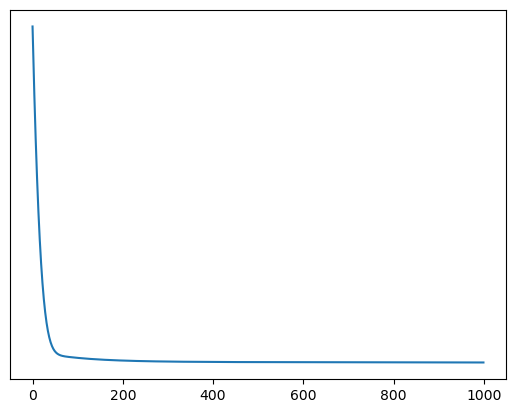

In [29]:
plt.plot(losses)
plt.yscale('symlog')

In [30]:
income_group_tensor.shape
# beta_income_vec.shape

params = guide()
with torch.no_grad():
    mu_tract_pred = (
        params['beta_0'] +
        params['beta_pop'] * pop +
        params['beta_income'] * income +
        params['beta_households'] * households
    )
    # mu_tract_pred = (
    #         params['beta_0'] +
    #         params['beta_pop'] * pop +
    #         params['beta_households'] * households
    #     ) + (income_group_tensor @ beta_income_vec)
    #
    damage_tract_pred = torch.exp(mu_tract_pred + 0.5 * params['sigma_tract'] ** 2)

    # Aggregate to county
    damage_county_pred = torch.zeros(num_counties, dtype=DTYPE, device=DEVICE).scatter_add(
        dim=0, index=storm_county_idx, src=damage_tract_pred
    )



In [15]:
# params = guide()
# with torch.no_grad():
#     # mu_tract_pred = (
#     #     params['beta_0'] +
#     #     params['beta_pop'] * pop +
#     #     params['beta_income'] * income +
#     #     params['beta_households'] * households
#     # )
#
#     mu_tract_pred = (
#         params['beta_0'] +
#         params['beta_pop'] * pop +
#         params['beta_households'] * households
#     )
#     beta_income_vec = torch.stack([
#         params[f'beta_income_group_{i}'] for i in range(income_group_tensor.shape[1])
#     ])
#     beta_income_vec = beta_income_vec - beta_income_vec.mean()
#
#     values = []
#     # Add income group contributions
#     for i in range(income_group_tensor.shape[1]):
#         values.append(beta_income_vec[i].cpu().numpy())
#         # print(beta_income_vec[i].cpu().numpy())
#         mu_tract_pred += beta_income_vec[i] * income_group_tensor[:, i]
#
#
#     # Predict mean damage in original space (accounting for LogNormal variance)
#     damage_tract_pred = torch.exp(mu_tract_pred + 0.5 * params['sigma_tract'] ** 2)
#
#     # Aggregate to county
#     damage_county_pred = torch.zeros(num_counties, dtype=DTYPE, device=DEVICE).scatter_add(
#         dim=0, index=storm_county_idx, src=damage_tract_pred
#     )

In [52]:
# plt.figure(figsize=(6, 6))
# plt.scatter(y_county.cpu().numpy(), damage_county_pred.cpu().numpy() / 1e14)
# plt.plot([0, 1e14], [0, 1e14], 'r--')
# plt.xlabel('True log1p(DAMAGE_PROPERTY)')
# plt.ylabel('Predicted')
#
# plt.yscale('symlog')
# plt.xscale('symlog')
# plt.grid(True)
# plt.show()


In [40]:
predicted_damages = damage_county_pred.cpu().numpy()

In [41]:
aggregated_damages_storm_county['storm'] = aggregated_damages_storm_county['storm_county'].str[0:6]
aggregated_damages_storm_county['predictions'] = predicted_damages

storm_damages = aggregated_damages_storm_county.groupby(['storm']).agg(
    {
        'DAMAGE_PROPERTY': 'sum',
        'predictions': 'sum',
    }
).reset_index()

In [42]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# income_labels = [
#     '<$10k', '$10–15k', '$15–20k', '$20–25k', '$25–30k',
#     '$30–35k', '$35–40k', '$40–45k', '$45–50k', '$50–60k',
#     '$60–75k', '$75–100k', '$100–125k', '$125–150k', '$150–200k', '>$200k'
# ]
#
# values = np.array(values)
# values = values - values.mean()  # should already be centered, but this ensures consistency
#
# fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
#
# bars = ax.bar(range(len(values)), values, width=0.6)
#
# ax.axhline(0, color='black', linewidth=1)
# ax.set_xticks(range(len(income_labels)))
# ax.set_xticklabels(income_labels, rotation=45, ha='right', fontsize=10)
# ax.set_ylabel('Relative effect on log-damage\n(per 1.0 increase in income bin share)', fontsize=12)
# ax.set_xlabel('Household Income Bin', fontsize=12)
# ax.set_title('Effect of Income Group Share on Hurricane Damages', fontsize=14, weight='bold')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_linewidth(1.2)
# ax.spines['bottom'].set_linewidth(1.2)
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_ylim(-170, 170)
#
# for i, v in enumerate(values):
#     ax.text(i, v + 0.01 * np.sign(v), f'{v:.2f}', ha='center', va='bottom' if v >= 0 else 'top', fontsize=8)
#
# plt.tight_layout()
# plt.show()

In [49]:
# bias correction
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(storm_damages['predictions'].values.reshape(-1, 1), storm_damages['DAMAGE_PROPERTY'])

model.coef_

array([2.564602e-14], dtype=float32)

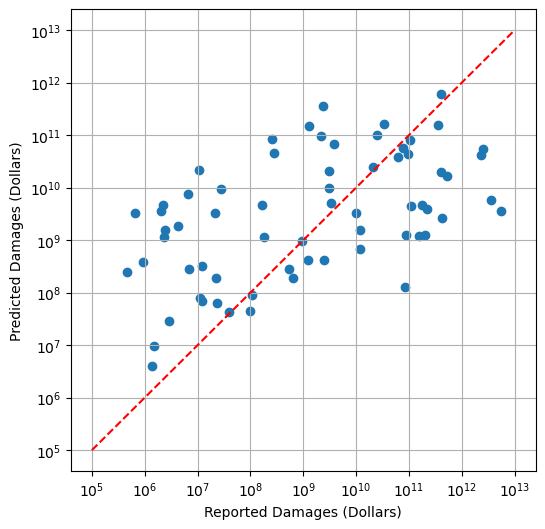

In [50]:
plt.figure(figsize=(6, 6))
plt.scatter(storm_damages['DAMAGE_PROPERTY'], storm_damages['predictions'] * model.coef_)
plt.plot([1e5, 1e13], [1e5, 1e13], 'r--')
# plt.xlabel('True log1p(DAMAGE_PROPERTY)')
plt.xlabel('Reported Damages (Dollars)')
plt.ylabel('Predicted Damages (Dollars)')
# plt.xlim([1e3, 1e13])
# plt.ylim([1e3, 1e13])
plt.yscale('symlog')
plt.xscale('symlog')
plt.grid(True)
plt.show()


In [51]:
print(r2_score(
    np.log10(storm_damages['DAMAGE_PROPERTY']),
    np.log10(storm_damages['predictions'] * model.coef_))
)

0.23513506947128926
